<a href="https://colab.research.google.com/github/SFStefenon/synthetic_ED/blob/main/cgans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

device: cpu
Image size: (719, 28, 28)
--- Label ---
label
2    175
1    123
5     81
0     79
8     64
3     57
4     55
9     42
7     25
6     18
Name: count, dtype: int64
[ 0/10][      0][    4.01s]	d_loss/g_loss:  3.4/0.21	
[ 1/10][     44][  132.52s]	d_loss/g_loss: -7.5/ 4.6	
[ 2/10][     88][  252.60s]	d_loss/g_loss: -8.5/ 4.2	
[ 3/10][    132][  375.24s]	d_loss/g_loss: -8.5/ 4.2	
[ 4/10][    176][  496.17s]	d_loss/g_loss: -6.6/0.34	
[ 5/10][    220][  619.71s]	d_loss/g_loss: -6.5/ 3.9	
[ 6/10][    264][  750.32s]	d_loss/g_loss: -6.5/ 3.9	
[ 7/10][    308][  875.59s]	d_loss/g_loss: -7.3/0.36	
[ 8/10][    352][  998.66s]	d_loss/g_loss: -5.7/ 1.6	
[ 9/10][    396][ 1121.91s]	d_loss/g_loss: -6.5/ 4.5	
Time (s): 1245.0716140270233 seconds
Time (h): 0.3458532261186176 hours


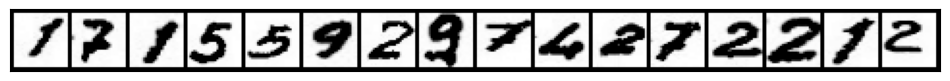

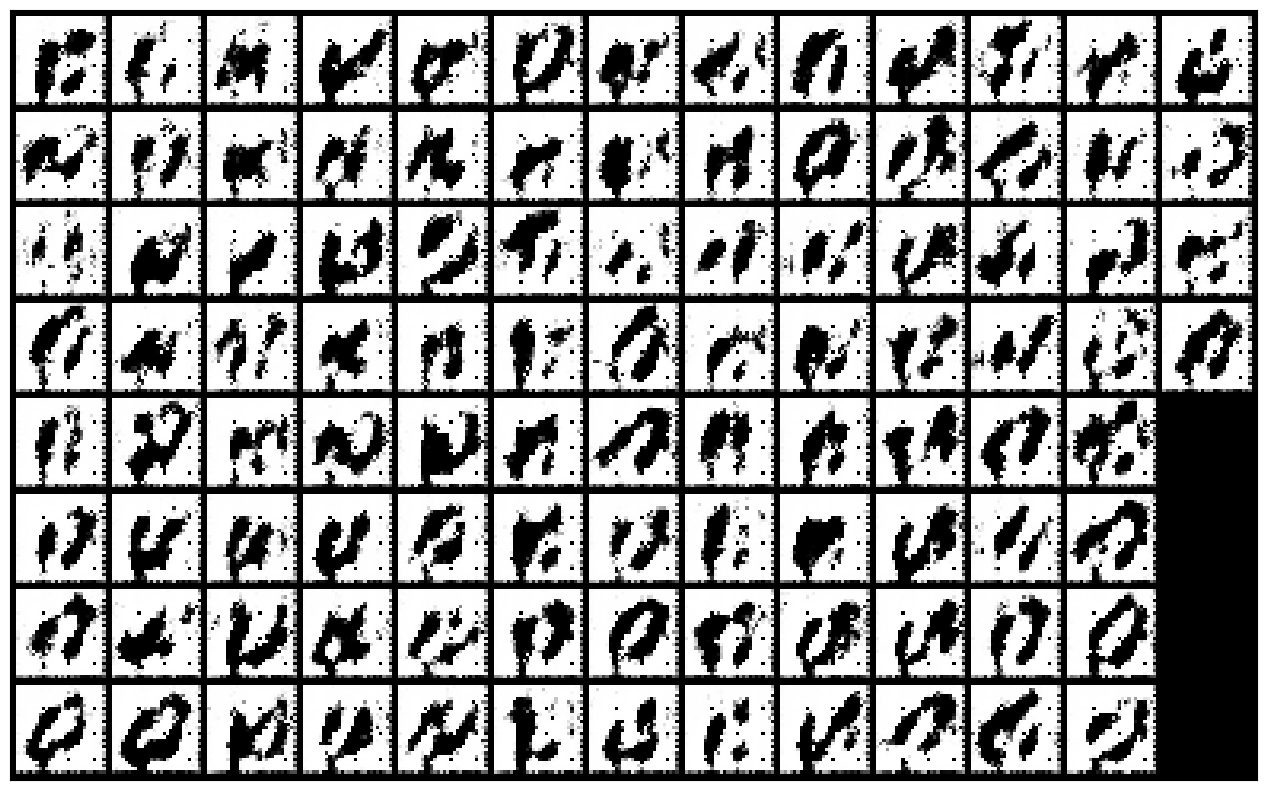

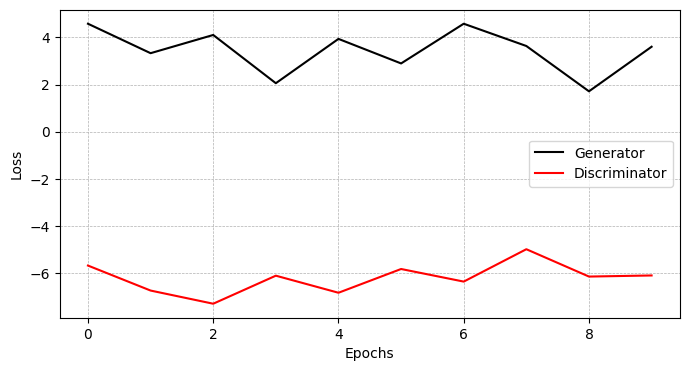

In [ ]:
import torch
from torch import nn, optim, autograd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from dataclasses import dataclass
import time
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
from torchvision.utils import make_grid
torch.set_num_threads(1)
torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

# Define the storage and dataset path
storage = ''
train_data_path = '28by28_rfi_train_perfect_labels_0.csv'

@dataclass
class Hyperparameter:
    num_classes: int        = 10
    samples_for_class: int  = 10
    batchsize: int          = 16
    num_epochs: int         = 10 # 5000
    latent_size: int        = 64
    n_critic: int           = 5
    critic_size: int        = 1024
    generator_size: int     = 1024
    critic_hidden_size: int = 1024
    gp_lambda: float        = 10.
hp = Hyperparameter()
img_size = 28
class_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

start = time.time()
class_num = len(class_list)
class RFI(Dataset):
    def __init__(self, path, img_size, transform=None):
        self.transform = transform
        rfi_df = pd.read_csv(path)
        self.images = rfi_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)
        self.labels = rfi_df.label.values
        print('Image size:', self.images.shape)
        print('--- Label ---')
        print(rfi_df.label.value_counts())
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.images[idx]
        img = Image.fromarray(self.images[idx])
        if self.transform:
            img = self.transform(img)
        return img, label

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
dataset = RFI(train_data_path, img_size, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=hp.batchsize, shuffle=True, drop_last=True)

for images, labels in dataloader:
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    plt.savefig(str(storage) + 'R_cGAN_image_original.pdf')
    break

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.latent_embedding = nn.Sequential(nn.Linear(hp.latent_size, hp.generator_size // 2),)
        self.condition_embedding = nn.Sequential(nn.Linear(hp.num_classes, hp.generator_size // 2),)
        self.tcnn = nn.Sequential(
        nn.ConvTranspose2d(hp.generator_size, hp.generator_size, 4, 1, 0),
        nn.BatchNorm2d(hp.generator_size),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(hp.generator_size, hp.generator_size // 2, 3, 2, 1),
        nn.BatchNorm2d(hp.generator_size // 2),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(hp.generator_size // 2, hp.generator_size // 4, 4, 2, 1),
        nn.BatchNorm2d(hp.generator_size // 4),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(hp.generator_size // 4, 1, 4, 2, 1),
        nn.Tanh())

    def forward(self, latent, condition):
        vec_latent = self.latent_embedding(latent)
        vec_class = self.condition_embedding(condition)
        combined = torch.cat([vec_latent, vec_class], dim=1).reshape(-1, hp.generator_size, 1, 1)
        return self.tcnn(combined)

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.condition_embedding = nn.Sequential(nn.Linear(hp.num_classes, hp.critic_size * 4),)
        self.cnn_net = nn.Sequential(
        nn.Conv2d(1, hp.critic_size // 4, 3, 2),
        nn.InstanceNorm2d(hp.critic_size // 4, affine=True),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(hp.critic_size // 4, hp.critic_size // 2, 3, 2),
        nn.InstanceNorm2d(hp.critic_size // 2, affine=True),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(hp.critic_size // 2, hp.critic_size, 3, 2),
        nn.InstanceNorm2d(hp.critic_size, affine=True),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Flatten(),)
        self.Critic_net = nn.Sequential(
        nn.Linear(hp.critic_size * 8, hp.critic_hidden_size),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(hp.critic_hidden_size, 1),)

    def forward(self, image, condition):
        vec_condition = self.condition_embedding(condition)
        cnn_features = self.cnn_net(image)
        combined = torch.cat([cnn_features, vec_condition], dim=1)
        return self.Critic_net(combined)

critic, generator = Critic().to(device), Generator().to(device)
critic_optimizer = optim.AdamW(critic.parameters(), lr=1e-4, betas=(0., 0.9))
generator_optimizer = optim.AdamW(generator.parameters(), lr=1e-4, betas=(0., 0.9))
img_list, generator_losses, critic_losses = [], [], []; iters = 0
generator_losses_ep, critic_losses_ep = [], [] # save it by epochs
all_labels = torch.eye(hp.num_classes, dtype=torch.float32, device=device)
fixed_noise = torch.randn((hp.samples_for_class*hp.num_classes, hp.latent_size), device=device)
fixed_class_labels = all_labels[[i for i in list(range(hp.num_classes)) for idx in range(hp.samples_for_class)]]
grad_tensor = torch.ones((hp.batchsize, 1), device=device)

start_time = time.time()
for epoch in range(hp.num_epochs):
    for batch_idx, data in enumerate(dataloader, 0):
        real_images, real_class_labels = data[0].to(device), all_labels[data[1]].to(device)
        # Update critic
        critic_optimizer.zero_grad()
        critic_output_real = critic(real_images, real_class_labels)
        critic_loss_real = critic_output_real.mean()

        noise = torch.randn((hp.batchsize, hp.latent_size), device=device)
        with torch.no_grad(): fake_image = generator(noise, real_class_labels)
        critic_output_fake = critic(fake_image, real_class_labels)
        critic_loss_fake = critic_output_fake.mean()

        alpha = torch.rand((hp.batchsize, 1), device=device)
        interpolates = (alpha.view(-1, 1, 1, 1) * real_images + ((1. - alpha.view(-1, 1, 1, 1)) * fake_image)).requires_grad_(True)
        d_interpolates = critic(interpolates, real_class_labels)
        gradients = autograd.grad(d_interpolates, interpolates, grad_tensor, create_graph=True, only_inputs=True)[0]
        gradient_penalty = hp.gp_lambda * ((gradients.view(hp.batchsize, -1).norm(dim=1) - 1.) ** 2).mean()
        critic_loss = - critic_loss_real + critic_loss_fake  + gradient_penalty

        critic_loss.backward()
        critic_optimizer.step()

        if batch_idx % hp.n_critic == 0:
            # Update Generator
            generator_optimizer.zero_grad()
            fake_class_labels = all_labels[torch.randint(hp.num_classes, size=[hp.batchsize])]
            noise = torch.randn((hp.batchsize, hp.latent_size), device=device)
            fake_image = generator(noise, fake_class_labels)
            critic_output_fake = critic(fake_image, fake_class_labels)
            generator_loss = - critic_output_fake.mean()
            generator_loss.backward()
            generator_optimizer.step()

        # Output training stats
        if batch_idx % 100 == 0:
            elapsed_time = time.time() - start_time
            print(f"[{epoch:>2}/{hp.num_epochs}][{iters:>7}][{elapsed_time:8.2f}s]\t"
                  f"d_loss/g_loss: {critic_loss.item():4.2}/{generator_loss.item():4.2}\t")

        # Save Losses for plotting later
        generator_losses.append(generator_loss.item())
        critic_losses.append(critic_loss.item())

        if (batch_idx == len(dataloader) - 1):
            generator_losses_ep.append(generator_loss.item())
            critic_losses_ep.append(critic_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise (save it by epoch)
        if (iters % 100 == 0) or ((epoch == hp.num_epochs - 1) and (batch_idx == len(dataloader) - 1)):
            with torch.no_grad(): fake_images = generator(fixed_noise, fixed_class_labels).cpu()
            # img_list.append(vutils.make_grid(fake_images, padding=2, normalize=True))
        iters += 1

torch.save(fake_images, str(storage) + 'R_cGAN_fake_images.pt')
torch.save(generator_losses_ep, str(storage) + 'R_cGAN_loss_generator.pt')
torch.save(critic_losses_ep, str(storage) + 'R_cGAN_loss_critic.pt')
plot_fake_img = vutils.make_grid(fake_images, padding=2, normalize=True)
for images in plot_fake_img:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=8).permute(2,1,0))
    plt.savefig(str(storage) + 'R_cGAN_image_generated.pdf')
    break

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 4))
ax1.plot(generator_losses_ep,'k', zorder=2, label='Generator')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epochs')
ax1.plot(critic_losses_ep, 'r', zorder=2, label='Discriminator')
ax1.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax1.legend()
plt.show
plt.savefig(str(storage) + 'R_cGAN_loss.pdf')

end = time.time()
time_s = end - start
time_h = time_s/3600
print(f'Time (s): {time_s} seconds')
print(f'Time (h): {time_h} hours')